# Projeto da Disciplina de Visão Computacional 3

**Treinar um modelo não generativo e um modelo generativo para o problema de Super Resolution.** 

**Base de dados:** https://www.kaggle.com/datasets/akhileshdkapse/super-image-resolution

**Rede baseada em:** https://medium.com/analytics-vidhya/super-resolution-using-autoencoders-and-tf2-0-505215c1674

## 1. Configurações

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import glob
import shutil
import matplotlib.pyplot as plt

import zipfile

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, Input, add, BatchNormalization
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 2. Carregando Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
local_zip = 'archive.zip'

zip_handle = zipfile.ZipFile(local_zip, 'r')

zip_handle.extractall('.')
zip_handle.close()

!ls

archive.zip  Data  sample_data	train  val


In [ ]:
inp_base_dir = 'Data'
dirnames = ['LR', 'HR']
out_base_dir = './'

In [ ]:
for dirname in dirnames:
    img_path = os.path.join(inp_base_dir, dirname)
    images = glob.glob(img_path + '/*.png')
    print("{}: {} Images".format(dirname, len(images)))
    num_train = int(round(len(images)*0.7))
    train, val = images[:num_train], images[num_train:]

    for t in train:
        if not os.path.exists(os.path.join(out_base_dir, 'train', dirname)):
            os.makedirs(os.path.join(out_base_dir, 'train', dirname))
        shutil.copy(t, os.path.join(out_base_dir, 'train', dirname))

    for v in val:
        if not os.path.exists(os.path.join(out_base_dir, 'val', dirname)):
            os.makedirs(os.path.join(out_base_dir, 'val', dirname))
        shutil.copy(v, os.path.join(out_base_dir, 'val', dirname))

LR: 100 Images
HR: 100 Images


In [ ]:
train_dir = os.path.join(out_base_dir,'train')
val_dir  = os.path.join(out_base_dir, 'val')

In [ ]:
IMG_SHAPE = 256
LATENT_DIM = 64
NUM_CHANNELS = 3

In [ ]:
def process_and_scale_train(filepath):
    img_input = tf.io.read_file(filepath)
    img_input = tf.image.decode_png(img_input)
    img_input = tf.image.resize(img_input,[IMG_SHAPE,IMG_SHAPE])
    
    img_output = tf.io.read_file(train_dir + tf.strings.join(["/HR/", tf.strings.split(filepath, os.sep)[-1]]))
    img_output = tf.image.decode_png(img_output)
    img_output = tf.image.resize(img_output,[IMG_SHAPE,IMG_SHAPE])
    
    return img_input/255., img_output/255.

In [ ]:
def process_and_scale_val(filepath):
    img_input = tf.io.read_file(filepath)
    img_input = tf.image.decode_png(img_input)
    img_input = tf.image.resize(img_input,[IMG_SHAPE,IMG_SHAPE])
    
    img_output = tf.io.read_file(val_dir + tf.strings.join(["/HR/", tf.strings.split(filepath, os.sep)[-1]]))
    img_output = tf.image.decode_png(img_output)
    img_output = tf.image.resize(img_output,[IMG_SHAPE,IMG_SHAPE])
    
    return img_input/255., img_output/255.

In [ ]:
train_ds_lr_files = tf.data.Dataset.list_files(train_dir + "/LR/*", shuffle = False)
val_ds_lr_files = tf.data.Dataset.list_files(val_dir + "/LR/*", shuffle = False)

In [ ]:
train_ds_lr_files.as_numpy_iterator().next()

b'./train/LR/0.png'

In [ ]:
train_data = train_ds_lr_files.shuffle(len(train_ds_lr_files)).map(process_and_scale_train).batch(8).prefetch(tf.data.AUTOTUNE)
val_data = val_ds_lr_files.map(process_and_scale_val).batch(8).prefetch(tf.data.AUTOTUNE)

### Visualizando input e output

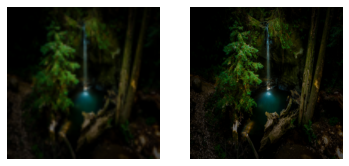

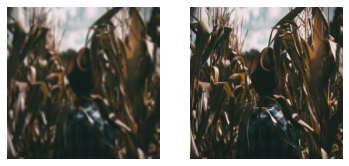

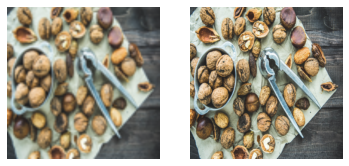

In [ ]:
for train_lr, train_hr in train_data.take(3):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(train_lr[0].numpy())
    ax[0].axis("off")
    ax[1].imshow(train_hr[0].numpy())
    ax[1].axis("off")

In [ ]:
def plot_model(model_name_history, erro):
    # Plot loss per iteration
    fig, ax = plt.subplots(1, 2,figsize=(17,8))

    ax[0].plot(model_name_history.history['loss'], label='loss')
    ax[0].plot(model_name_history.history['val_loss'], label='val_loss')
    ax[0].legend()
    
    # Plot rmse per iteration
    ax[1].plot(model_name_history.history[erro], label=erro)
    val_erro = 'val_' + erro
    ax[1].plot(model_name_history.history[val_erro], label=val_erro)
    ax[1].legend()

In [ ]:
def plot_result(n, pred):
    for img_input, img_output in val_data.take(1):
        fig, ax = plt.subplots(1,3, figsize = (20,15))
        ax[0].imshow(img_input.numpy()[n])
        ax[0].axis("off")
        ax[1].imshow(pred[n])
        ax[1].axis("off")
        ax[2].imshow(img_output.numpy()[n])
        ax[2].axis("off")

    # Compute PSNR over tf.float32 Tensors.
    im1 = tf.image.convert_image_dtype(pred[n], tf.float32)
    im2 = tf.image.convert_image_dtype(img_output.numpy()[n], tf.float32)
    psnr2 = tf.image.psnr(im1, im2, max_val=255.0)
    print(f"PSNR: {psnr2}")
    # psnr1 and psnr2 both have type tf.float32 and are almost equal.

## 3. Modelos

In [ ]:
EPOCHS = 200

### Modelo 1


*   Camadas: 16
*   Learning Rate: 0.01
*   Metrica: RMSE
*   Loss: Mean Absolute Error
*   Ephocs: 200



In [ ]:
#EPOCHS = 200

#### Encoder

In [ ]:
#codigos sugerido pelo DeepLearningAI

def encoder(inputs):
    '''Defines the encoder with two Conv2D and max pooling layers.'''

    c1 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(inputs)
    c2 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(c1)
    mp1 = MaxPool2D(padding='same')(c2)

    c3 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(mp1)
    c4 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(c3)
    mp2 = MaxPool2D(padding='same')(c4)

    return mp2, c2, c4

#### BottleNeck

In [ ]:
def bottle_neck(inputs):
    '''Defines the bottleneck.'''

    bottle_neck = Conv2D(256, (3,3), , activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(inputs)

    return bottle_neck

#### Decoder

In [ ]:
def decoder(inputs, c2_enc, c4_enc):
    '''Defines the decoder path to upsample back to the original image size.'''

    ct1 = Conv2DTranspose(64, 3, activation='relu', padding='same', strides=(2,2))(inputs)
    c1 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(ct1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(c1)

    add1 = add([c2, c4_enc])

    ct2 = Conv2DTranspose(64, 3, activation='relu', padding='same', strides=(2,2))(add1)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10, ))(ct2)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(c3)

    add2 = add([c4, c2_enc])

    decoded_image = Conv2D(3, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(add2)

    return decoded_image

#### Modelo

In [ ]:
def auto_encoder_super_resolution():
  '''Builds the entire autoencoder model.'''

  inputs = Input(shape=(IMG_SHAPE, IMG_SHAPE, 3,))
  encoder_output, c2_encoder, c4_encoder = encoder(inputs)
  bottleneck_output = bottle_neck(encoder_output)
  decoder_output = decoder(bottleneck_output, c2_encoder, c4_encoder)
  
  model = tf.keras.Model(inputs =inputs, outputs=decoder_output)
  
  return model

In [ ]:
model_1 = auto_encoder_super_resolution()
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

#### Treinamento

In [ ]:
opt = tf.keras.optimizers.Adadelta(learning_rate=0.01)
metric = [tf.keras.metrics.RootMeanSquaredError(name = 'rmse')]

In [ ]:
model_1.compile(optimizer = opt, #optimizer='adam', #optimizer='adadelta',
                    loss='mean_absolute_error', 
                    metrics = metric)

In [ ]:
model_history_1 = model_1.fit(train_data,
                                validation_data = val_data,
                                epochs = EPOCHS) 

Epoch 1/200
9/9 [==============================] - 15s 664ms/step - loss: 0.2743 - rmse: 0.3221 - val_loss: 0.2601 - val_rmse: 0.3086
Epoch 2/200
9/9 [==============================] - 3s 353ms/step - loss: 0.2695 - rmse: 0.3153 - val_loss: 0.2543 - val_rmse: 0.3000
Epoch 3/200
9/9 [==============================] - 3s 373ms/step - loss: 0.2652 - rmse: 0.3090 - val_loss: 0.2490 - val_rmse: 0.2921
Epoch 4/200
9/9 [==============================] - 3s 333ms/step - loss: 0.2609 - rmse: 0.3026 - val_loss: 0.2440 - val_rmse: 0.2847
Epoch 5/200
9/9 [==============================] - 3s 335ms/step - loss: 0.2572 - rmse: 0.2972 - val_loss: 0.2394 - val_rmse: 0.2782
Epoch 6/200
9/9 [==============================] - 3s 336ms/step - loss: 0.2537 - rmse: 0.2923 - val_loss: 0.2354 - val_rmse: 0.2727
Epoch 7/200
9/9 [==============================] - 3s 337ms/step - loss: 0.2508 - rmse: 0.2881 - val_loss: 0.2318 - val_rmse: 0.2681
Epoch 8/200
9/9 [==============================] - 3s 337ms/step - l

#### Vizualizando Loss

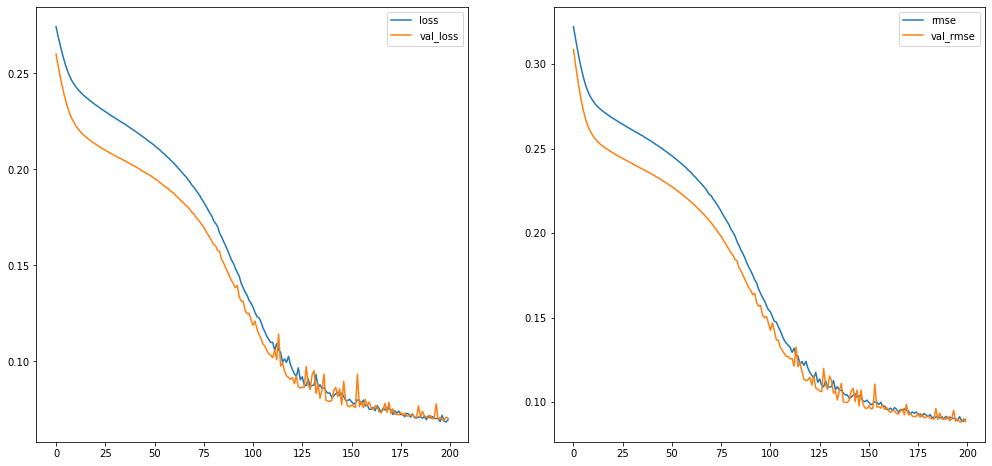

In [ ]:
plot_model(model_history_1, 'rmse')

### Modelo 2


*   Camadas: 16
*   Learning Rate: 0.001
*   Metrica: RMSE
*   Loss: Mean Absolute Error
*   Ephocs: 250



In [ ]:
EPOCHS = 250

In [ ]:
model_2 = auto_encoder_super_resolution()

#### Treinamento

In [ ]:
opt = tf.keras.optimizers.Adadelta(learning_rate=0.001)
metric = [tf.keras.metrics.RootMeanSquaredError(name = 'rmse')]

In [ ]:
model_2.compile(optimizer = opt, #optimizer='adam', #optimizer='adadelta',
                    loss='mean_absolute_error', 
                    metrics = metric)

In [ ]:
model_history_2 = model_2.fit(train_data,
                                validation_data = val_data,
                                epochs = EPOCHS) 

Epoch 1/250
9/9 [==============================] - 5s 377ms/step - loss: 0.2960 - rmse: 0.3580 - val_loss: 0.2810 - val_rmse: 0.3384
Epoch 2/250
9/9 [==============================] - 3s 350ms/step - loss: 0.2949 - rmse: 0.3565 - val_loss: 0.2796 - val_rmse: 0.3367
Epoch 3/250
9/9 [==============================] - 3s 350ms/step - loss: 0.2938 - rmse: 0.3550 - val_loss: 0.2783 - val_rmse: 0.3350
Epoch 4/250
9/9 [==============================] - 3s 349ms/step - loss: 0.2928 - rmse: 0.3536 - val_loss: 0.2771 - val_rmse: 0.3334
Epoch 5/250
9/9 [==============================] - 3s 351ms/step - loss: 0.2918 - rmse: 0.3522 - val_loss: 0.2758 - val_rmse: 0.3318
Epoch 6/250
9/9 [==============================] - 3s 351ms/step - loss: 0.2908 - rmse: 0.3508 - val_loss: 0.2746 - val_rmse: 0.3302
Epoch 7/250
9/9 [==============================] - 3s 351ms/step - loss: 0.2899 - rmse: 0.3493 - val_loss: 0.2735 - val_rmse: 0.3288
Epoch 8/250
9/9 [==============================] - 3s 354ms/step - lo

#### Vizualizando Loss

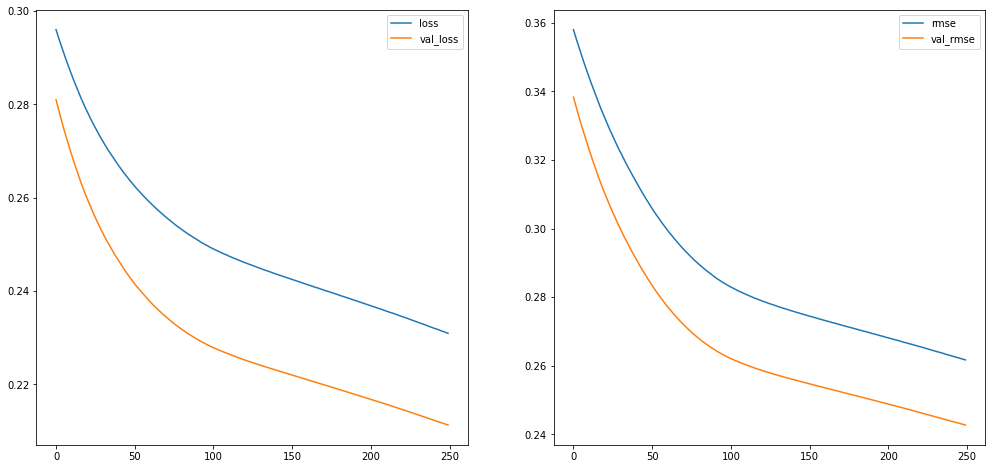

In [ ]:
plot_model(model_history_2, 'rmse')

### Modelo 3


*   Camadas: 16
*   Learning Rate: 0.0001
*   Metrica: RMSE
*   Loss: Mean Absolute Error
*   Ephocs: 300



In [ ]:
EPOCHS = 300

In [ ]:
model_3 = auto_encoder_super_resolution()

#### Treinamento

In [ ]:
opt = tf.keras.optimizers.Adadelta(learning_rate=0.0001)
metric = [tf.keras.metrics.RootMeanSquaredError(name = 'rmse')]

In [ ]:
model_3.compile(optimizer = opt, #optimizer='adam', #optimizer='adadelta',
                    loss='mean_absolute_error', 
                    metrics = metric)

In [ ]:
model_history_3 = model_3.fit(train_data,
                                validation_data = val_data,
                                epochs = EPOCHS) 

Epoch 1/300
9/9 [==============================] - 5s 382ms/step - loss: 0.2858 - rmse: 0.3304 - val_loss: 0.2732 - val_rmse: 0.3179
Epoch 2/300
9/9 [==============================] - 3s 349ms/step - loss: 0.2857 - rmse: 0.3302 - val_loss: 0.2730 - val_rmse: 0.3177
Epoch 3/300
9/9 [==============================] - 3s 351ms/step - loss: 0.2856 - rmse: 0.3301 - val_loss: 0.2729 - val_rmse: 0.3175
Epoch 4/300
9/9 [==============================] - 3s 349ms/step - loss: 0.2854 - rmse: 0.3299 - val_loss: 0.2728 - val_rmse: 0.3174
Epoch 5/300
9/9 [==============================] - 3s 349ms/step - loss: 0.2853 - rmse: 0.3298 - val_loss: 0.2726 - val_rmse: 0.3172
Epoch 6/300
9/9 [==============================] - 3s 349ms/step - loss: 0.2852 - rmse: 0.3296 - val_loss: 0.2725 - val_rmse: 0.3171
Epoch 7/300
9/9 [==============================] - 3s 351ms/step - loss: 0.2851 - rmse: 0.3295 - val_loss: 0.2723 - val_rmse: 0.3169
Epoch 8/300
9/9 [==============================] - 3s 350ms/step - lo

#### Vizualizando Loss

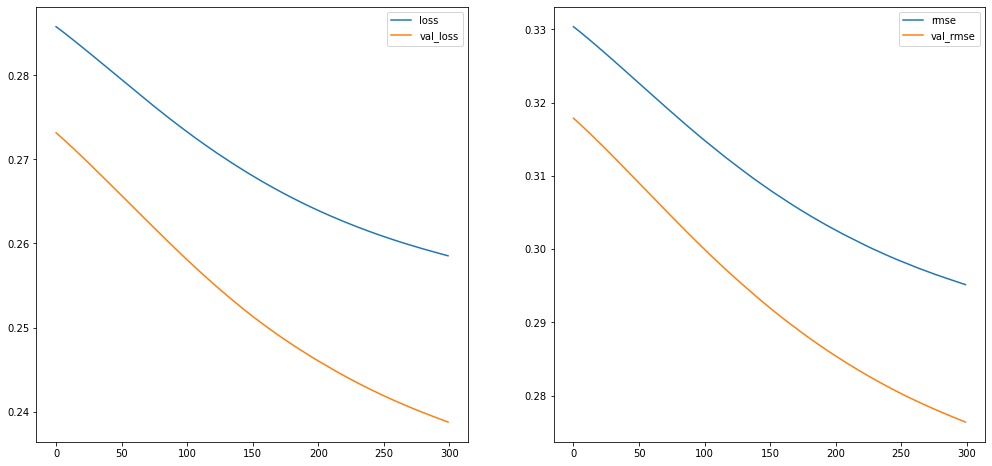

In [ ]:
plot_model(model_history_3, 'rmse')

### Modelo 4


*   Camadas: 16
*   Learning Rate: 0.0001
*   Metrica: MSE
*   Loss: Mean Squared Error
*   Ephocs: 300

In [ ]:
model_4 = auto_encoder_super_resolution()

#### Treinamento

In [ ]:
opt = tf.keras.optimizers.Adadelta(learning_rate=0.0001)
metric = [tf.keras.metrics.MeanSquaredError(name = 'mse')]

In [ ]:
model_4.compile(optimizer = opt, #optimizer='adam', #optimizer='adadelta',
                    loss='mean_squared_error', 
                    metrics = metric)

In [ ]:
model_history_4 = model_4.fit(train_data,
                                validation_data = val_data,
                                epochs = EPOCHS)

Epoch 1/300
9/9 [==============================] - 6s 427ms/step - loss: 0.1509 - mse: 0.1451 - val_loss: 0.1440 - val_mse: 0.1378
Epoch 2/300
9/9 [==============================] - 3s 363ms/step - loss: 0.1508 - mse: 0.1450 - val_loss: 0.1439 - val_mse: 0.1377
Epoch 3/300
9/9 [==============================] - 3s 346ms/step - loss: 0.1507 - mse: 0.1449 - val_loss: 0.1438 - val_mse: 0.1376
Epoch 4/300
9/9 [==============================] - 3s 350ms/step - loss: 0.1506 - mse: 0.1448 - val_loss: 0.1437 - val_mse: 0.1375
Epoch 5/300
9/9 [==============================] - 3s 351ms/step - loss: 0.1505 - mse: 0.1447 - val_loss: 0.1436 - val_mse: 0.1374
Epoch 6/300
9/9 [==============================] - 3s 351ms/step - loss: 0.1504 - mse: 0.1447 - val_loss: 0.1435 - val_mse: 0.1373
Epoch 7/300
9/9 [==============================] - 3s 352ms/step - loss: 0.1503 - mse: 0.1446 - val_loss: 0.1434 - val_mse: 0.1372
Epoch 8/300
9/9 [==============================] - 3s 353ms/step - loss: 0.1502 - m

#### Visualizando Loss

In [ ]:
pred = model_4.predict(val_data.take(1))

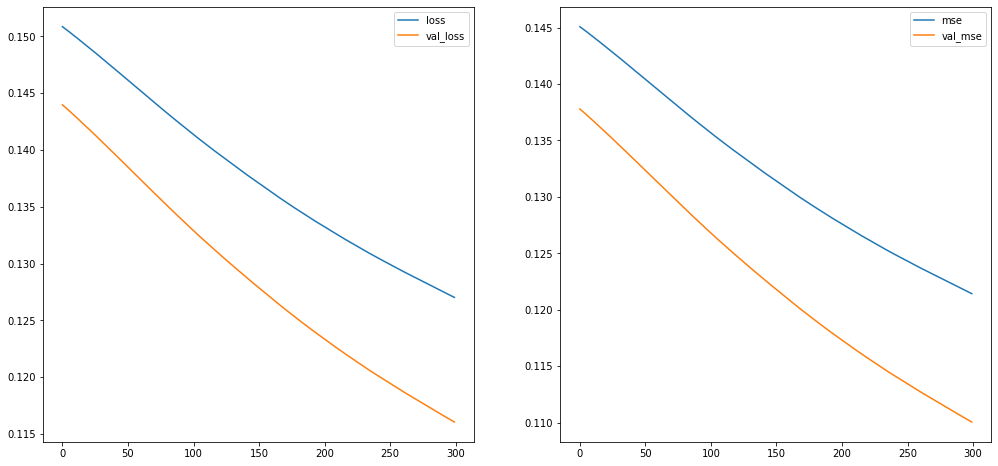

In [ ]:
plot_model(model_history_4, 'mse')

### Modelo 5


*   Camadas: 30
*   Learning Rate: 0.0001
*   Metrica: MSE
*   Loss: Mean Squared Error
*   Ephocs: 300



#### Encoder

In [ ]:
#codigos sugerido pelo DeepLearningAI

def encoder(inputs):
    '''Defines the encoder with two Conv2D and max pooling layers.'''

    c1 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(inputs)
    c2 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(c1)
    mp1 = MaxPool2D(padding='same')(c2)

    c3 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(mp1)
    c4 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(c3)
    mp2 = MaxPool2D(padding='same')(c4)

    c5 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(mp2)
    c6 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(c5)
    mp3 = MaxPool2D(padding='same')(c6)
    
    c7 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(mp3)
    c8 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(c7)
    mp4 = MaxPool2D(padding='same')(c8)

    return mp4, c2, c4, c6, c8

#### BottleNeck

In [ ]:
def bottle_neck(inputs):
    '''Defines the bottleneck.'''

    bottle_neck = Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(inputs)

    return bottle_neck

#### Decoder

In [ ]:
def decoder(inputs, c2_enc, c4_enc, c6_enc, c8_enc):
    '''Defines the decoder path to upsample back to the original image size.'''

    ct1 = Conv2DTranspose(64, 3, activation='relu', padding='same', strides=(2,2))(inputs)
    c1 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(ct1)
    c2 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(c1)

    add1 = add([c2, c8_enc])

    ct2 = Conv2DTranspose(64, 3, activation='relu', padding='same', strides=(2,2))(add1)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(ct2)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(c3)

    add2 = add([c4, c6_enc])

    ct3 = Conv2DTranspose(64, 3, activation='relu', padding='same', strides=(2,2))(add2)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(ct3)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(c5)

    add3 = add([c6, c4_enc])

    ct4 = Conv2DTranspose(64, 3, activation='relu', padding='same', strides=(2,2))(add3)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(ct4)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(c7)

    add4 = add([c8, c2_enc])

    decoded_image = Conv2D(3, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(add4)

    return decoded_image

#### Modelo

In [ ]:
def auto_encoder_super_resolution():
  '''Builds the entire autoencoder model.'''

  inputs = Input(shape=(IMG_SHAPE, IMG_SHAPE, 3,))
  encoder_output, c2_enc, c4_enc, c6_enc, c8_enc = encoder(inputs)
  bottleneck_output = bottle_neck(encoder_output)
  decoder_output = decoder(bottleneck_output, c2_enc, c4_enc, c6_enc, c8_enc)
  
  model = tf.keras.Model(inputs =inputs, outputs=decoder_output)
  
  return model

In [ ]:
model_5 = auto_encoder_super_resolution()
model_5.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 256, 256, 32  896         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_41 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_40[0][0]']              
                                )                                                           

#### Treinamento

In [ ]:
opt = tf.keras.optimizers.Adadelta(learning_rate=0.0001)
metric = [tf.keras.metrics.MeanSquaredError(name = 'mse')]

In [ ]:
model_5.compile(optimizer = opt, #optimizer='adam', #optimizer='adadelta',
                    loss='mean_squared_error', 
                    metrics = metric)

In [ ]:
model_history_5 = model_5.fit(train_data,
                                validation_data = val_data,
                                epochs = EPOCHS) 

Epoch 1/300
9/9 [==============================] - 10s 609ms/step - loss: 0.2573 - mse: 0.2536 - val_loss: 0.2889 - val_mse: 0.2851
Epoch 2/300
9/9 [==============================] - 2s 234ms/step - loss: 0.2565 - mse: 0.2529 - val_loss: 0.2880 - val_mse: 0.2842
Epoch 3/300
9/9 [==============================] - 2s 237ms/step - loss: 0.2558 - mse: 0.2521 - val_loss: 0.2871 - val_mse: 0.2833
Epoch 4/300
9/9 [==============================] - 2s 237ms/step - loss: 0.2550 - mse: 0.2514 - val_loss: 0.2862 - val_mse: 0.2824
Epoch 5/300
9/9 [==============================] - 2s 235ms/step - loss: 0.2543 - mse: 0.2506 - val_loss: 0.2853 - val_mse: 0.2815
Epoch 6/300
9/9 [==============================] - 2s 236ms/step - loss: 0.2535 - mse: 0.2499 - val_loss: 0.2844 - val_mse: 0.2806
Epoch 7/300
9/9 [==============================] - 2s 237ms/step - loss: 0.2528 - mse: 0.2491 - val_loss: 0.2836 - val_mse: 0.2797
Epoch 8/300
9/9 [==============================] - 2s 237ms/step - loss: 0.2521 - 

#### Vizualizando Loss

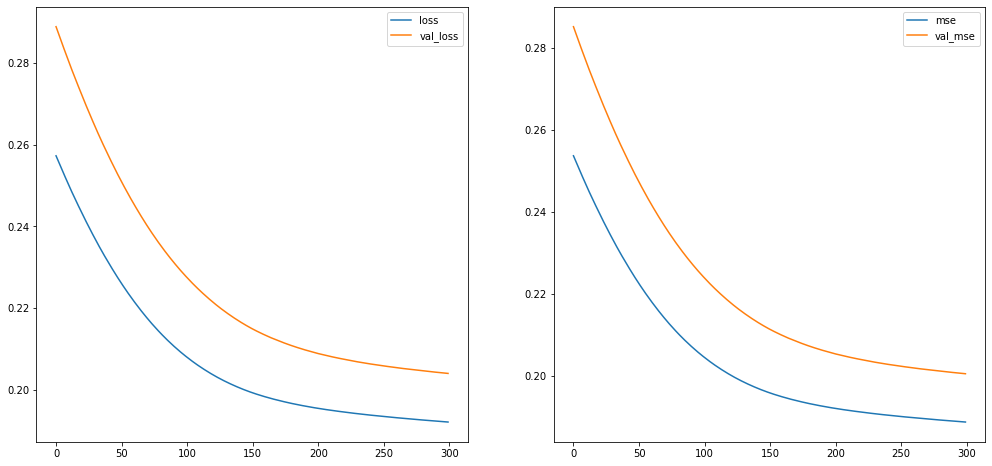

In [ ]:
plot_model(model_history_5, 'mse')

### Modelo 6


*   Camadas: 23
*   Learning Rate: 0.01
*   Metrica: MSE
*   Loss: Mean Squared Error
*   Ephocs: 300



#### Encoder

In [ ]:
#codigos sugerido pelo DeepLearningAI

def encoder(inputs):
    '''Defines the encoder with two Conv2D and max pooling layers.'''

    c1 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(inputs)
    c2 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(c1)
    mp1 = MaxPool2D(padding='same')(c2)

    c3 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(mp1)
    c4 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(c3)
    mp2 = MaxPool2D(padding='same')(c4)

    c5 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(mp2)
    c6 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(c5)
    mp3 = MaxPool2D(padding='same')(c6)

    return mp3, c2, c4, c6

#### BottleNeck

In [ ]:
def bottle_neck(inputs):
    '''Defines the bottleneck.'''

    bottle_neck = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(inputs)

    return bottle_neck

#### Decoder

In [ ]:
def decoder(inputs, c2_enc, c4_enc, c6_enc):
    '''Defines the decoder path to upsample back to the original image size.'''

    ct1 = Conv2DTranspose(64, 3, activation='relu', padding='same', strides=(2,2))(inputs)
    c1 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(ct1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(c1)

    add1 = add([c2, c6_enc])

    ct2 = Conv2DTranspose(64, 3, activation='relu', padding='same', strides=(2,2))(add1)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(ct2)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(c3)

    add2 = add([c4, c4_enc])

    ct3 = Conv2DTranspose(64, 3, activation='relu', padding='same', strides=(2,2))(add2)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(ct3)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(c5)

    add2 = add([c6, c2_enc])

    decoded_image = Conv2D(3, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', activity_regularizer=l1(10e-10))(add2)

    return decoded_image

#### Modelo

In [ ]:
def auto_encoder_super_resolution():
  '''Builds the entire autoencoder model.'''

  inputs = Input(shape=(IMG_SHAPE, IMG_SHAPE, 3,))
  encoder_output, c2_encoder, c4_encoder, c6_encoder = encoder(inputs)
  bottleneck_output = bottle_neck(encoder_output)
  decoder_output = decoder(bottleneck_output, c2_encoder, c4_encoder, c6_encoder)
  
  model = tf.keras.Model(inputs =inputs, outputs=decoder_output)
  
  return model

In [ ]:
model_6 = auto_encoder_super_resolution()
model_6.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

#### Treinamento

In [ ]:
opt = tf.keras.optimizers.Adadelta(learning_rate=0.01)
metric = [tf.keras.metrics.MeanSquaredError(name = 'mse')]

In [ ]:
model_6.compile(optimizer = opt, #optimizer='adam', #optimizer='adadelta',
                    loss='mean_squared_error', 
                    metrics = metric)

In [ ]:
model_history_6 = model_6.fit(train_data,
                                validation_data = val_data,
                                epochs = 200) 

Epoch 1/200
9/9 [==============================] - 21s 490ms/step - loss: 0.2323 - mse: 0.2287 - val_loss: 0.1855 - val_mse: 0.1819
Epoch 2/200
9/9 [==============================] - 2s 206ms/step - loss: 0.1614 - mse: 0.1579 - val_loss: 0.1417 - val_mse: 0.1382
Epoch 3/200
9/9 [==============================] - 2s 211ms/step - loss: 0.1284 - mse: 0.1250 - val_loss: 0.1176 - val_mse: 0.1141
Epoch 4/200
9/9 [==============================] - 2s 206ms/step - loss: 0.1095 - mse: 0.1061 - val_loss: 0.1032 - val_mse: 0.0997
Epoch 5/200
9/9 [==============================] - 2s 208ms/step - loss: 0.0980 - mse: 0.0946 - val_loss: 0.0942 - val_mse: 0.0908
Epoch 6/200
9/9 [==============================] - 2s 207ms/step - loss: 0.0908 - mse: 0.0874 - val_loss: 0.0885 - val_mse: 0.0850
Epoch 7/200
9/9 [==============================] - 2s 206ms/step - loss: 0.0858 - mse: 0.0824 - val_loss: 0.0839 - val_mse: 0.0804
Epoch 8/200
9/9 [==============================] - 2s 212ms/step - loss: 0.0811 - 

#### Vizualizando Loss

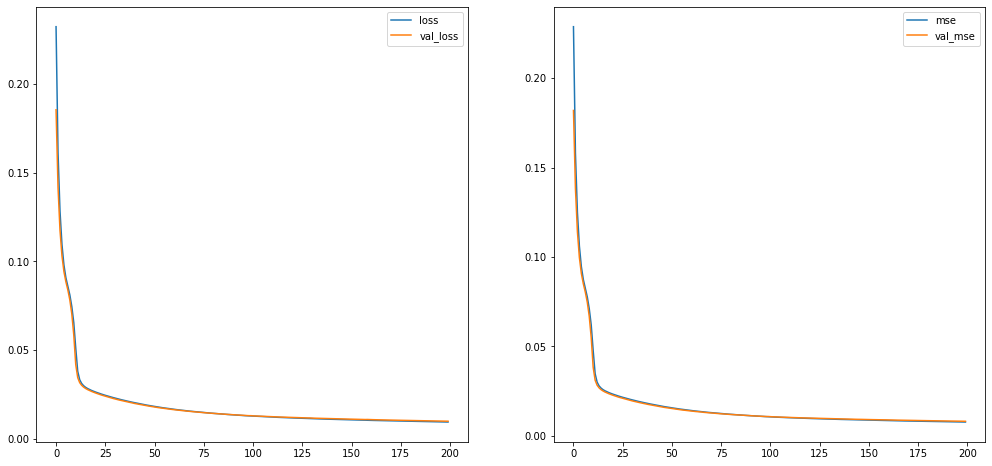

In [ ]:
plot_model(model_history_6, 'mse')

## 4. Resultados 

### Visualizando Resultados

In [ ]:
pred_list = []

PSNR: 67.65422058105469


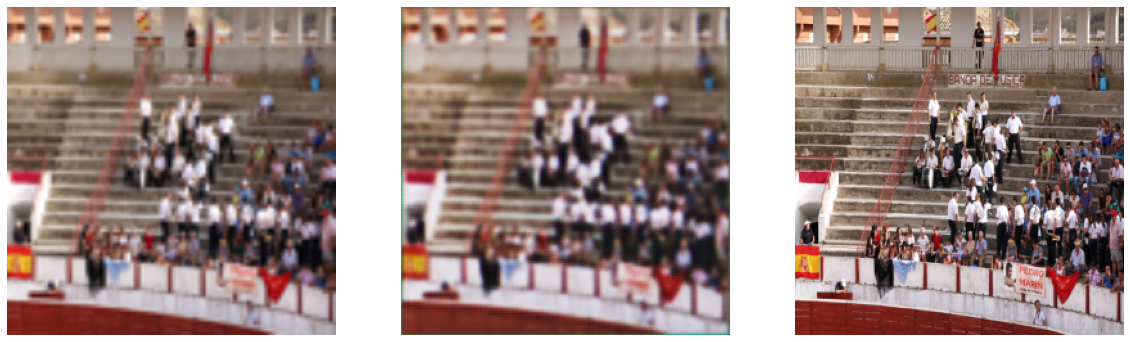

In [ ]:
pred_list.append(model_1.predict(val_data.take(4)))
plot_result(4, pred_list[0])

PSNR: 61.17750549316406


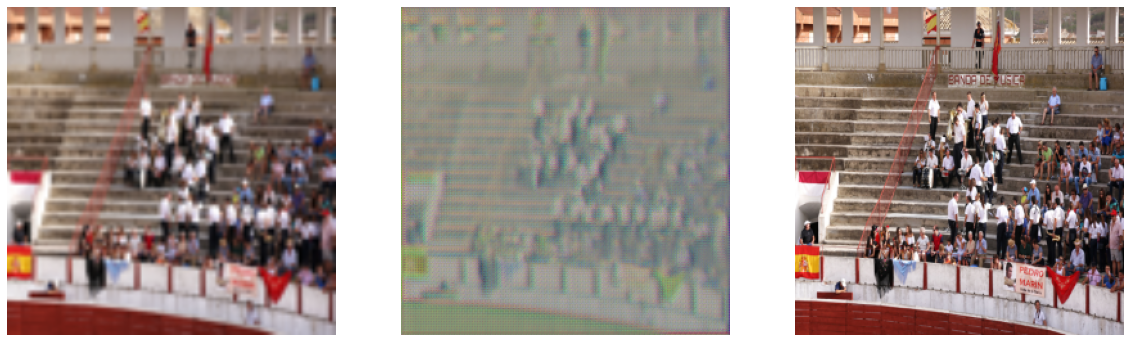

In [ ]:
pred_list.append(model_2.predict(val_data.take(4)))
plot_result(4, pred_list[1])

PSNR: 60.096797943115234


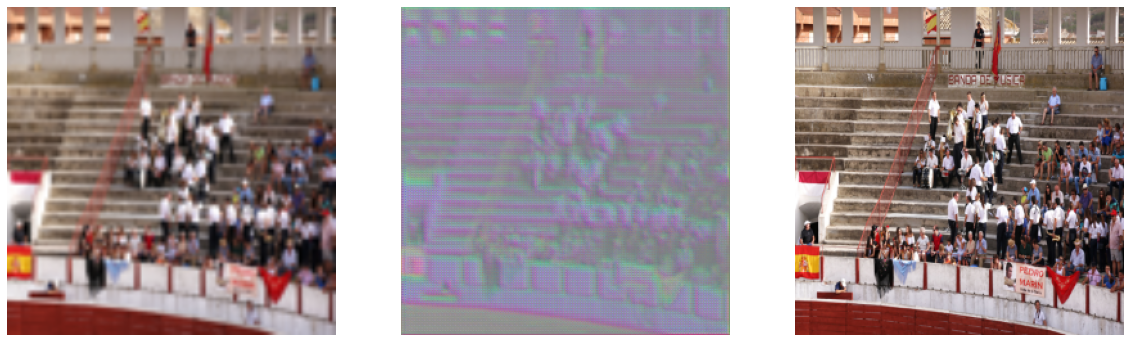

In [ ]:
pred_list.append(model_3.predict(val_data.take(4)))
plot_result(4, pred_list[2])

PSNR: 58.15332794189453


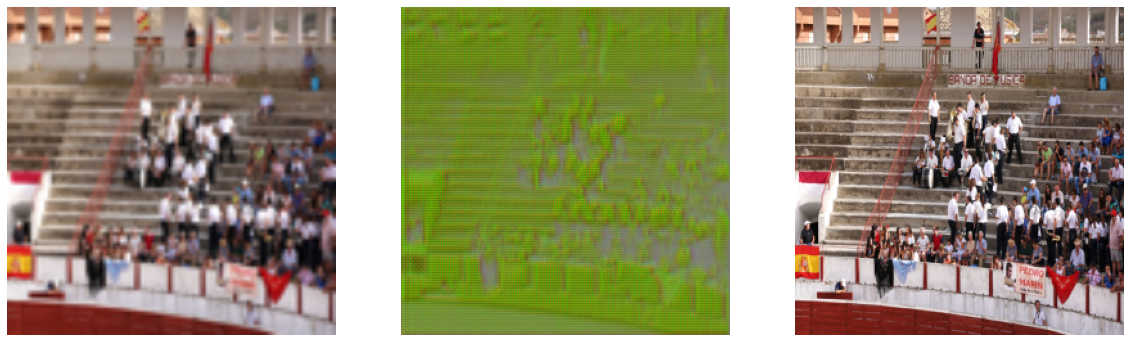

In [ ]:
pred_list.append(model_4.predict(val_data.take(4)))
plot_result(4, pred_list[3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR: 54.53848648071289


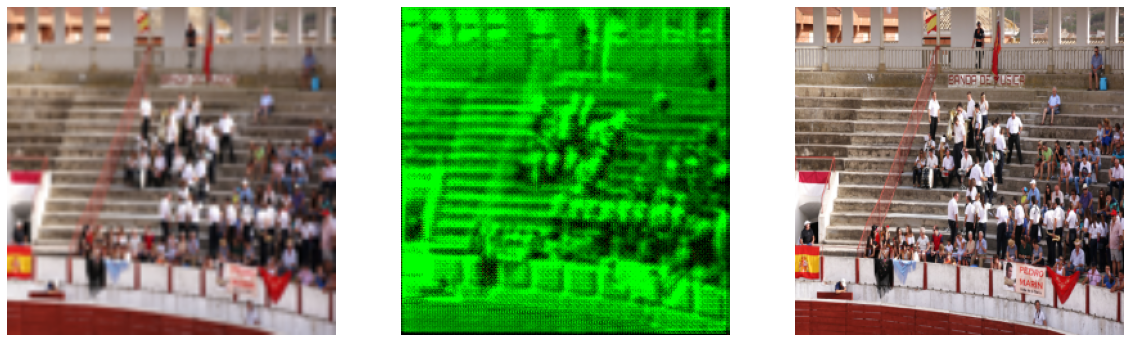

In [ ]:
pred_list.append(model_5.predict(val_data.take(4)))
plot_result(4, pred_list[4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR: 68.41094970703125


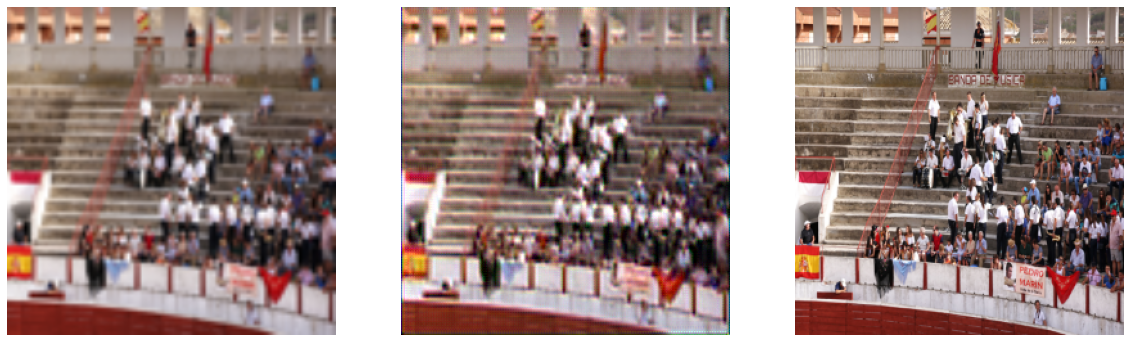

In [ ]:
pred_list.append(model_6.predict(val_data.take(4)))
plot_result(4, pred_list[5])

PSNR: 65.77288055419922


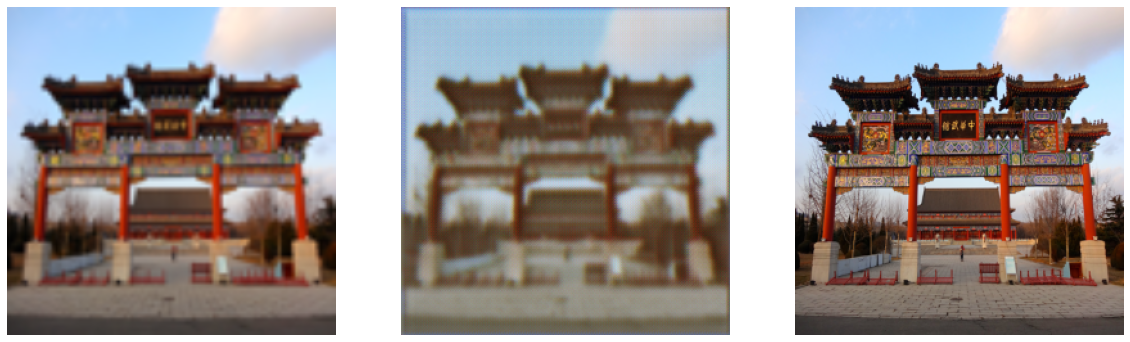

In [ ]:
pred_list.append(model_6.predict(val_data.take(4)))
plot_result(4, pred_list[1])

### Média do PSNR das imagen preditas

In [ ]:
from matplotlib.cbook import iterable

def psnr_mean(pred):
    psnr = 0
    n_pred = 0
    n_out = 0
    for img_input, img_output in val_data.take(4):
        for img in img_output:

            fig, ax = plt.subplots(1,3, figsize = (20,15))
            ax[0].imshow(img_input.numpy()[n_out])
            ax[0].axis("off")
            ax[1].imshow(pred[n_pred])
            ax[1].axis("off")
            ax[2].imshow(img_output.numpy()[n_out])
            ax[2].axis("off")

            # Compute PSNR over tf.float32 Tensors.
            im1 = tf.image.convert_image_dtype(pred[n_pred], tf.float32)
            n_pred += 1
            im2 = tf.image.convert_image_dtype(img_output.numpy()[n_out], tf.float32)
            if n_out == 7:
                n_out = 0
            else:
                n_out += 1
            psnr += tf.image.psnr(im1, im2, max_val=255.0)

    return psnr / pred.shape[0]

In [ ]:
n = 1
for pred in pred_list:
    mean = psnr_mean(pred)
    print(f'PSNR médio do módelo {n}: {mean}')
    n += 1

PSNR médio do módelo 1: 69.43199920654297
PSNR médio do módelo 2: 60.766395568847656
PSNR médio do módelo 3: 59.625511169433594
PSNR médio do módelo 4: 58.025169372558594
PSNR médio do módelo 5: 55.78630065917969
PSNR médio do módelo 6: 70.51306915283203


In [ ]:
n = 1
for pred in pred_list:
    mean = psnr_mean(pred)
    print(f'PSNR médio do módelo {n}: {mean}')
    n += 1

PSNR médio do módelo 1: 69.64328002929688


In [ ]:
n = 1
for pred in pred_list:
    mean = psnr_mean(pred)
    print(f'PSNR médio do módelo {n}: {mean}')
    n += 1